In [17]:
from segment_anything import SamPredictor, sam_model_registry
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [18]:
sam = sam_model_registry["vit_h"](checkpoint="checkpoints/sam_vit_h_4b8939.pth")
sam.to(device)
predictor = SamPredictor(sam)

In [19]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

## Selecting objects with points

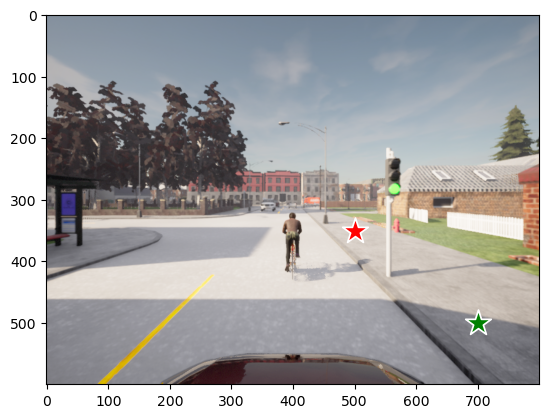

In [47]:
image = cv2.imread("carla_frame.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

input_point = np.array([[500, 350], [700, 500]])
input_label = np.array([0, 1])

show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [48]:
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

In [49]:
masks.shape  # (number_of_masks) x H x W

(1, 600, 800)

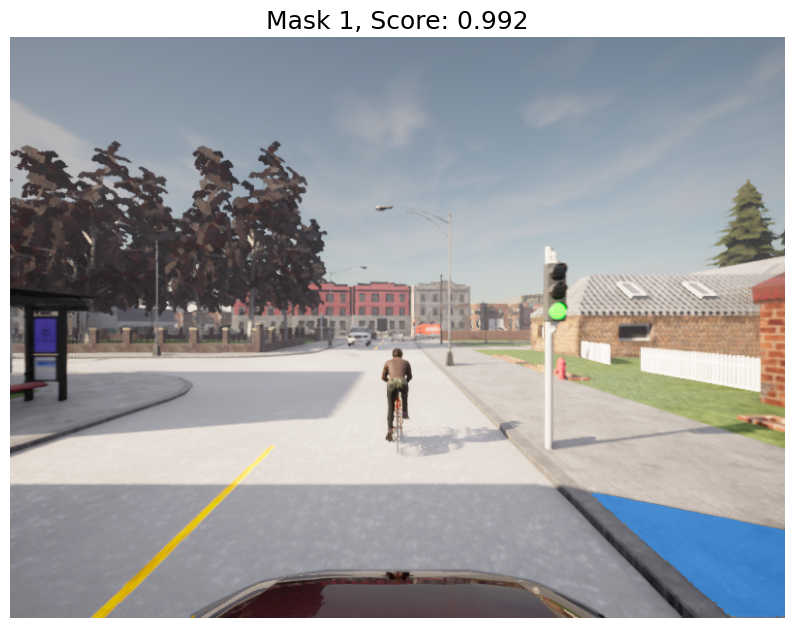

In [50]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    # show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

## Selecting Objects with boxes

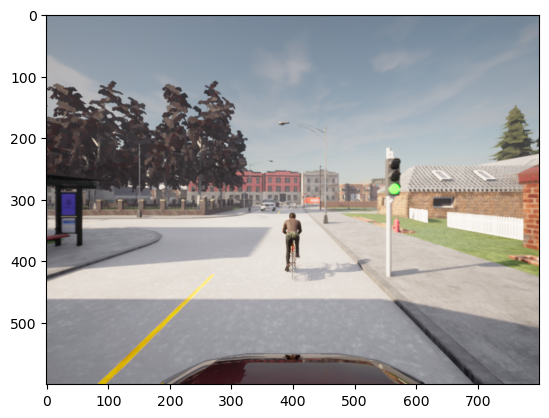

In [54]:
image = cv2.imread("carla_frame.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('on')
plt.show()  

In [70]:
input_box = np.array([375, 315, 425, 430])

In [71]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

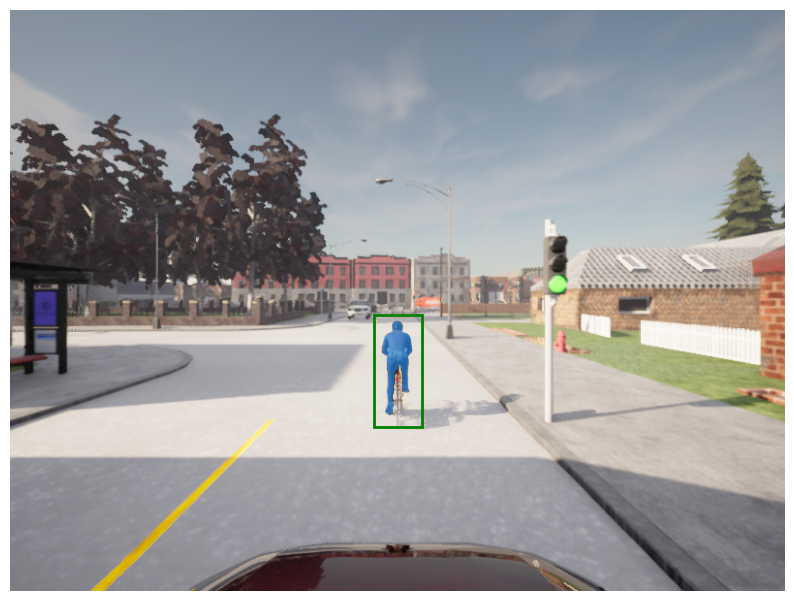

In [72]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

## Combine boxes and points

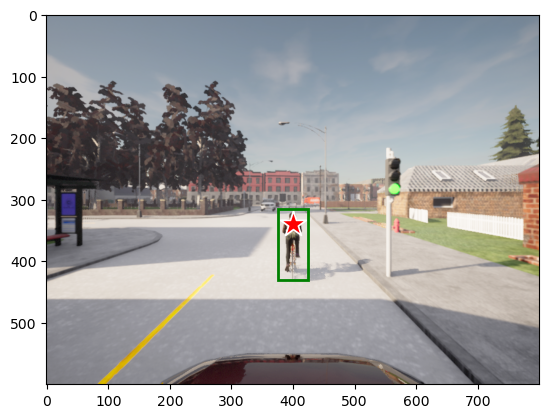

In [83]:
input_box = np.array([375, 315, 425, 430])
input_point = np.array([[400, 340]])
input_label = np.array([0])

plt.imshow(image)

show_points(input_point, input_label, plt.gca())
show_box(input_box, plt.gca())
plt.axis('on')
plt.show()  

In [84]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

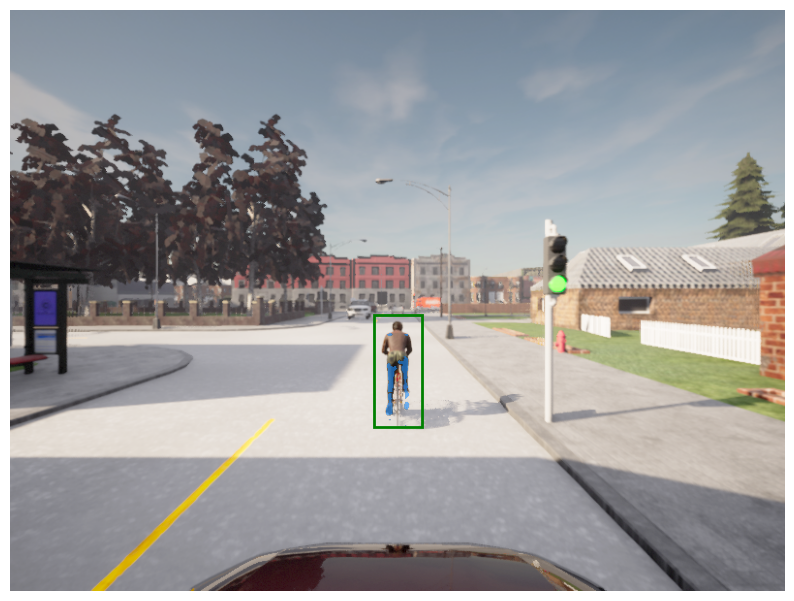

In [85]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
# show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

## Batch Predict

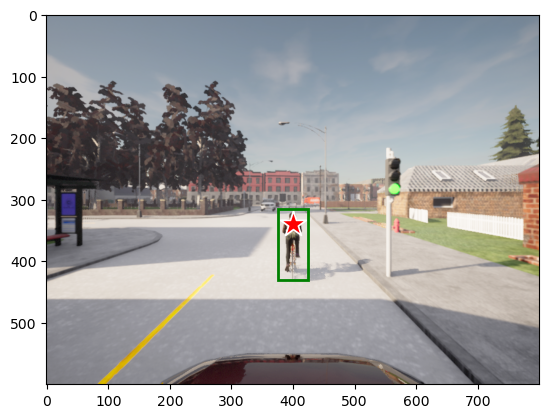

In [86]:
input_box = np.array([375, 315, 425, 430])
input_point = np.array([[400, 340]])
input_label = np.array([0])

plt.imshow(image)

show_points(input_point, input_label, plt.gca())
show_box(input_box, plt.gca())
plt.axis('on')
plt.show()  

In [91]:
input_boxes = torch.tensor([
    [375, 315, 425, 430],
    [550, 215, 575, 425],
    [200, 550, 600, 600],
], device=predictor.device)

In [92]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [93]:
masks.shape  # (batch_size) x (num_predicted_masks_per_input) x H x W

torch.Size([3, 1, 600, 800])

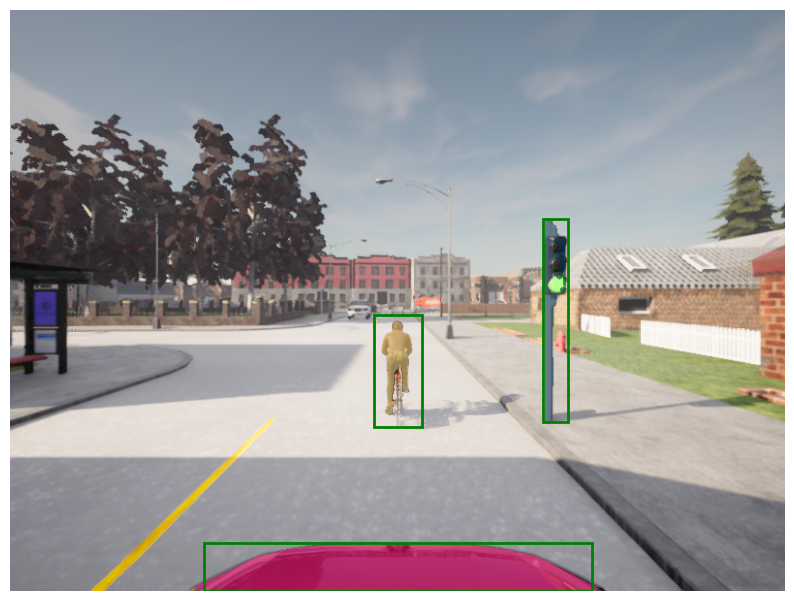

In [94]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

### End-to-end batch inference

In [97]:
input_boxes = torch.tensor([
    [375, 315, 425, 430],
    [550, 215, 575, 425],
    [200, 550, 600, 600],
], device=predictor.device)

image2 = cv2.imread('coco_chilino.jpeg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image2_boxes = torch.tensor([
    [300, 225, 780, 700],
    [1025, 300, 1300, 700],
], device=sam.device)

plt.imshow(image2)

In [98]:
from segment_anything.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device.device) 
    return image.permute(2, 0, 1).contiguous()

In [101]:
batched_input = [
     {
         'image': prepare_image(image, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(input_boxes, image.shape[:2]),
         'original_size': image.shape[:2]
     },
     {
         'image': prepare_image(image2, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image2_boxes, image2.shape[:2]),
         'original_size': image2.shape[:2]
     }
]

In [102]:
batched_output = sam(batched_input, multimask_output=False)

In [103]:
batched_output[0].keys()

dict_keys(['masks', 'iou_predictions', 'low_res_logits'])

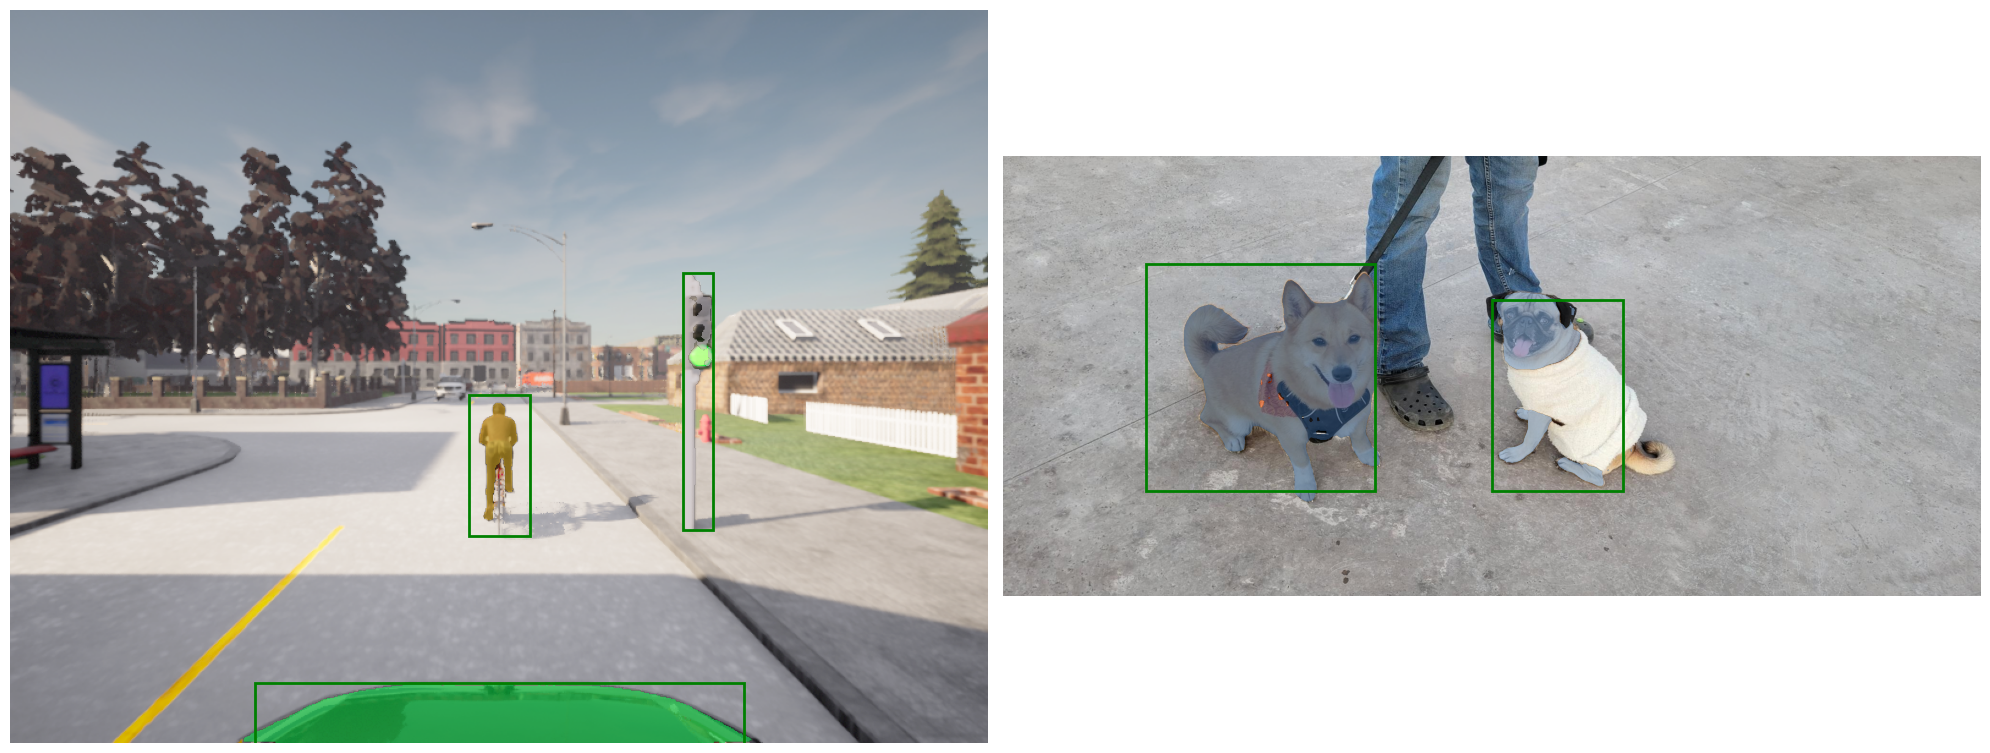

In [105]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

ax[0].imshow(image)
for mask in batched_output[0]['masks']:
    show_mask(mask.cpu().numpy(), ax[0], random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), ax[0])
ax[0].axis('off')

ax[1].imshow(image2)
for mask in batched_output[1]['masks']:
    show_mask(mask.cpu().numpy(), ax[1], random_color=True)
for box in image2_boxes:
    show_box(box.cpu().numpy(), ax[1])
ax[1].axis('off')

plt.tight_layout()
plt.show()